<a href="https://colab.research.google.com/github/elhamod/BA820/blob/main/Hands-on/03-dimensionality-reduction/Dimensionality_Reduction_Hands_on_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course: BA820 - Unsupervised and Unstructured ML**

**Notebook created by: Mohannad Elhamod**

#Food Nutrients Analysis

In this notebook, we will try to analyze the nutrients found in the [food in Google's cafeterias](https://huggingface.co/datasets/mmathys/food-nutrients).

We will see how to apply dimensionality reduction, and how that could help with downstream tasks, such as classification and clustering.

## Load the data

Let's load the datasets and see what information it provides. (this may take a minute or two).

In [1]:
!pip install mlcroissant

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 22.8 MB/s eta 0:00:00
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15130 sha256=5c95b284d0c9776b1ed5448d19accde25724bcae547b833233b3c08cf2359cb9
  Stored in directory: /root/.cache/pip/wheels/53/cf/51/a4ea10224b7fdb523e18e2033cadf2a8657517d1f95f3f5413
Successfully built jsonpath-rw


In [2]:
from mlcroissant import Dataset
import pandas as pd

ds = Dataset(jsonld="https://huggingface.co/api/datasets/mmathys/food-nutrients/croissant")
records = ds.records("default")

# Remove the 'image' column and strip 'default/' prefix from keys
filtered_records = [
    {k.replace("default/", ""): v for k, v in record.items() if k != "default/image"}
    for record in records
]

# Convert filtered records to a Pandas DataFrame
df = pd.DataFrame(filtered_records)

  -  [Metadata(food-nutrients)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(food-nutrients)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(food-nutrients)] Property "https://schema.org/version" is recommended, but does not exist.
  -  `description` has cardinality `ONE`, but got a list
  -  `source` has cardinality `ONE`, but got a list


##EDA

We have some information on the ingrediants, and some nutrition values, such as protien, fat, etc.

Let's remove the features we don't care about and do some preprocessing.

In [3]:
# Removing features
df.drop("split", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)

# Some preprocessing for the ingredients column to extract ingredients as text.
df["ingredients"] = [",".join([(ingredient["default/ingredients/name"]).decode('utf-8') for ingredient in lst_ingredients]) for lst_ingredients in df["ingredients"]]

# A separate dataframe just with the numeric values.
df_numeric = df.drop("ingredients", axis=1)

In [4]:
df_numeric

,total_calories,total_mass,total_fat,total_carb,total_protein
0,41.399998,36.0,3.852000,2.268000,0.288000
1,6.440000,23.0,0.092000,1.219000,0.506000
2,71.299995,62.0,6.634000,3.906000,0.496000
3,27.520000,64.0,0.192000,5.760000,2.176000
4,4.480000,28.0,0.056000,0.952000,0.196000
...,...,...,...,...,...
3255,55.800003,268.0,0.692000,10.969999,4.532000
3256,93.400002,348.0,0.852000,19.770000,7.172000
3257,443.199982,560.0,8.483999,19.770000,72.892006
3258,743.760010,594.0,42.484001,19.770000,72.891998


Let's see how these dimensions interact.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable h

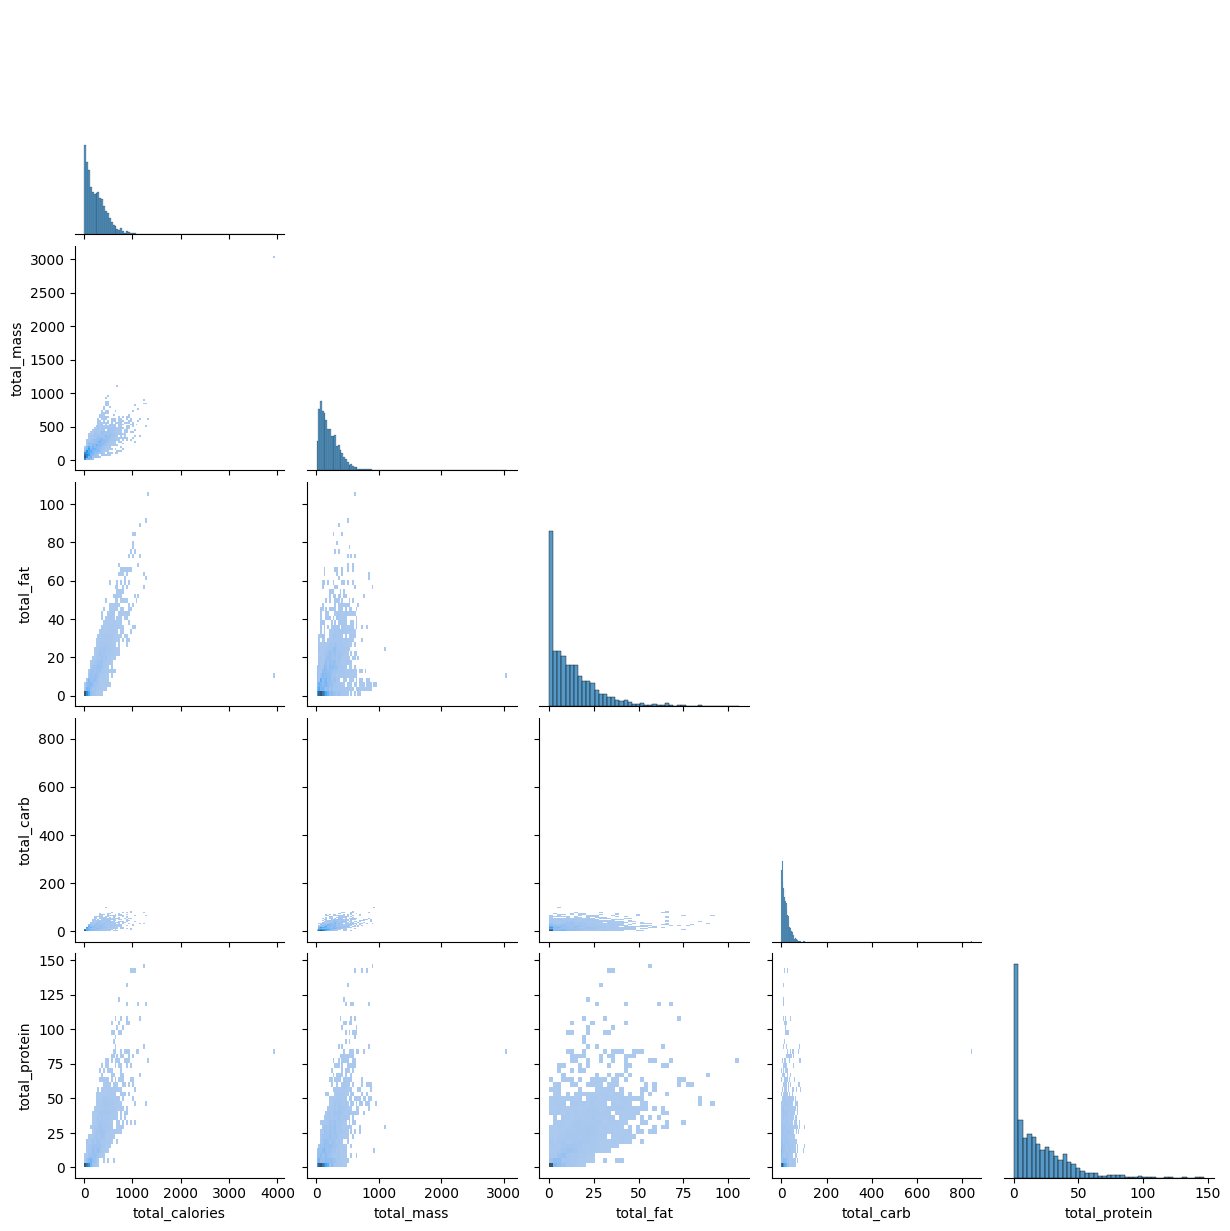

In [5]:
import seaborn as sns

sns.pairplot(df, kind="hist", corner=True, palette="Set2")

<Axes: >

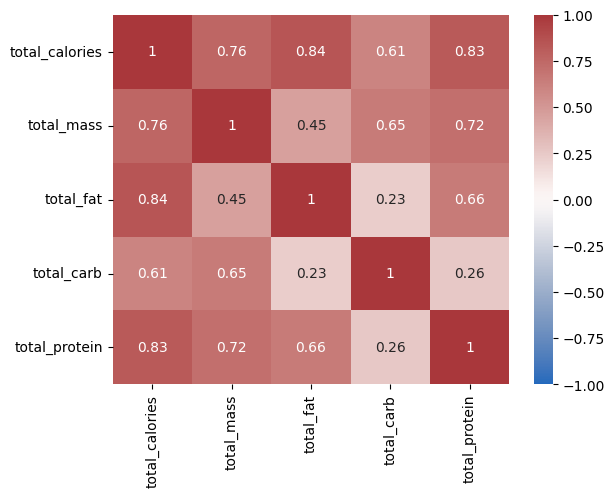

In [6]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="vlag" , vmin=-1, vmax=1)

## Dimentionality Reduction with PCA

Let's start with PCA, assuming features may align linearly.

First we need to normalize the data.

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
normalized_data = sc.fit_transform(df_numeric)
normalized_data

array([[-0.97353507, -1.10914212, -0.65682573, -0.79293827, -0.88449092],
       [-1.13274783, -1.18965598, -0.93483339, -0.84149589, -0.87361411],
       [-0.83736626, -0.94811439, -0.45112964, -0.71711617, -0.87411305],
       ...,
       [ 0.85631878,  2.13618593, -0.31434404,  0.01721949,  2.73798535],
       [ 2.22511158,  2.34676066,  2.19955512,  0.01721949,  2.73798495],
       [ 2.2611803 ,  2.40250102,  2.19955512,  0.08804238,  2.74023046]])

Then, we perform PCA.

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

# Create the model
model =

#fit the data
model.

# transform the data
transformed_data =
transformed_data_df = pd.DataFrame(transformed_data)

# Rename the columns
transformed_data_df.columns = [f"PC{i+1}" for i in range(df_numeric.shape[1])]

transformed_data_df

Let's take a look at how the data varies along each PC.

In [ ]:
transformed_data_df.describe()

Let's look at the PCA components.

In [ ]:
components_df = pd.DataFrame()

# Rename the columns
components_df.columns = df_numeric.columns

# Rename the rows
components_df.index = [f"PC{i+1}" for i in range(components_df.shape[0])]

components_df

**Question:** What is the magnitude (i.e., length) of each principal component?

In [ ]:
corr = df.corr(numeric_only=True)
sns.heatmap(components_df, annot=True, cmap="vlag" , )

###Feature Importance

In [ ]:
model.explained_variance_

Let's look at the explained variance of the model and print the scree plot using [`psynlig`](https://psynlig.readthedocs.io/en/latest/).

In [ ]:
!pip install psynlig

In [ ]:
from matplotlib import pyplot as plt
from psynlig import (
    pca_explained_variance,
    pca_explained_variance_bar,
)

_, ax = pca_explained_variance(model,  marker='o', markersize=8, alpha=0.8)

# Let's add a line at an explained variance of 90%
ax.axhline(y=0.9, color='r', linestyle='--', linewidth=2)

plt.show()

pca_explained_variance_bar(
    model,
    width=0.2,
    alpha=0.8,
    color='black',
)

plt.show()

### Computing the Loadings

Let's plot the scaled version of these components by scaling each of the components in proportion to their standard deviations (i.e., square root of `model.explained_variance_`). This is called the **loadings**.

In [ ]:
import numpy as np
loadings =

loadings_df = pd.DataFrame(loadings)
loadings_df

**Question:** If I move by 1 step along PC1, how many calories do I gain or lose?

Let's overlay the PCA components on top of the original features. We will use [`yellowbricks`](https://www.scikit-yb.org/en/latest/).

In [ ]:
from yellowbrick.features import PCA as PCA_visualizer

visualizer = PCA_visualizer(featureslist=df_numeric.columns,
                            projection=2,
                            proj_features=True,
                            heatmap=True
                            )
visualizer.fit_transform(pd.DataFrame(normalized_data, columns=df_numeric.columns))
visualizer.show()

We could also use [`psynlig`](https://psynlig.readthedocs.io/en/latest/)

In [ ]:
from psynlig import pca_2d_scores

loading_settings = {
    'adjust_text': True,
    'add_text': True,
}

pca_2d_scores(
    model,
    transformed_data,
    xvars=df_numeric.columns,
    select_components={(1, 2)},
    loading_settings=loading_settings,
    s=200,
    alpha=.8,
    cmap_class='Dark2',
)



plt.show()

Using `plotly` may help us with a more detailed investigation.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# add ingredients column for visualization
transformed_data_with_ingredients_df = pd.concat([transformed_data_df, df["ingredients"]], axis=1)

# Create a 3D scatter plot
fig = px.scatter_3d( #scatter_3d scatter
    transformed_data_with_ingredients_df,
    x="PC1",  # First principal component
    y="PC2",  # Second principal component
    z="PC3",  # Third principal component
    hover_name="ingredients",
)

fig.update_traces(
    marker=dict(
        size=2,  # Smaller marker size
        opacity=0.3  # Transparency (alpha)
    )
)


# Add an arrow for each original dimensions
for i, feature in enumerate(loadings_df.columns):
    fig.add_trace(
        go.Scatter3d(
            x=[0, loadings_df.loc["PC1", feature]],
            y=[0, loadings_df.loc["PC2", feature]],
            z=[0, loadings_df.loc["PC3", feature]],
            mode="lines",
            line=dict(color="red", width=3),
            showlegend=False,
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=[loadings_df.loc["PC1", feature]],
            y=[loadings_df.loc["PC2", feature]],
            z=[loadings_df.loc["PC3", feature]],
            mode="text",
            showlegend=False,
            text=[f"<b>{feature}</b>"],  # Bold text for better readability
            textfont=dict(size=12, color="red"),  # Match text color to the line
            textposition="middle right",  # Position the text more naturally
        )
    )

# Set axes ranges for easier display (removing outlier from display)
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-5, 10]),  # X-axis range
        yaxis=dict(range=[-5, 5]),   # Y-axis range
        zaxis=dict(range=[-2, 4])    # Z-axis range
    )
)

# Show the plot
fig.show()

## Clustering with and without PCA

###Outlier Removal

Let's remove the outliers first. That may help us get a better clustering. One way to do that is to find points with high reconstruction error.

In [ ]:
from sklearn.metrics import mean_squared_error

reconstructed_data =

# Calculate reconstruction error (MSE)
reconstruction_errors =

Only keep indices that are within 3 standard deviation of error.

In [ ]:
# Compute mean and standard deviation of the errors


# Filter indices within 3 standard deviations
valid_indices =

In [ ]:
valid_indices.shape

###Clustering in Original Space

Let's compare clustering results with and without PCA

First, let's do the original data frame.

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='silhouette', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(normalized_data[valid_indices, :])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

kmeans = KMeans(2)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(normalized_data[valid_indices, :])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Let's plot the clusters.

In [ ]:
df_original_withlabels = df.iloc[valid_indices]
df_original_withlabels["cluster_labels"] = kmeans.labels_

import plotly.express as px
fig = px.scatter_3d(df_original_withlabels, x='total_calories', y='total_carb', z='total_fat', color='cluster_labels',
                    opacity=0.5, color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_traces(marker=dict(size=3))  # Adjust the size to make dots smaller
fig.show()

###Clustering in a PCA-Low Dimensional Space

Let's now cluster with 1, 2, or 3 major PC components.

In [ ]:
low_dimensional_df =

In [ ]:
kmeans = KMeans()
visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='distortion', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(low_dimensional_df.iloc[valid_indices])        # Fit the data to the visualizer
visualizer.show()

In [ ]:
kmeans = KMeans(4)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(low_dimensional_df.iloc[valid_indices])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Let's plot these clusters in the original space. What filtering and transformations do we need?

In [ ]:
df_PCA_withlabels =
df_PCA_withlabels =
df_PCA_withlabels =
df_PCA_withlabels = pd.DataFrame(df_PCA_withlabels)
df_PCA_withlabels.columns = df_numeric.columns
df_PCA_withlabels["cluster_labels"] =

# Add ingredients column to the UMAP DataFrame for hover information
df_PCA_withlabels["ingredients"] =

import plotly.express as px
fig = px.scatter_3d(df_PCA_withlabels, x=, y=, z=, color=,
                    hover_name=,
                    opacity=0.5, color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_traces(marker=dict(size=3))  # Adjust the size to make dots smaller
fig.show()

## UMAP

Finally, let's see if UMAP gives better results.

In [ ]:
!pip install umap-learn

In [ ]:
import umap
import plotly.express as px

# Use UMAP to reduce the dimensionality of the data
reducer = umap.
umap_embeddings = reducer.

# Create a DataFrame for the UMAP embeddings
umap_df = pd.DataFrame(umap_embeddings, columns=["UMAP1", "UMAP2", "UMAP3"]) #

# Add ingredients column to the UMAP DataFrame for hover information
umap_df["ingredients"] = df["ingredients"][valid_indices].values

# Create a 3D scatter plot with hover information
fig = px.scatter_3d(
    umap_df,
    x=,
    y=,
    z=,
    hover_name="ingredients",  # Show ingredients on hover
    opacity=0.5,
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Customize marker size and opacity
fig.update_traces(marker=dict(size=3, opacity=0.7))

# Display the plot
fig.show()

Let's try some clusterning on this embedding space.

In [ ]:
kmeans = KMeans()
visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='distortion', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(umap_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**Question:** What do you notice about the silhouette score if you try a large number of clusters? Can you explain your observation and judge whether it is a good idea to use  a lot of clusters?

In [ ]:
kmeans = KMeans(4)
kmeans.fit(umap_embeddings)

umap_df_withlabels = pd.DataFrame(umap_embeddings)
umap_df_withlabels.columns =
umap_df_withlabels["cluster_labels"] = _
umap_df_withlabels["ingredients"] =

import plotly.express as px
fig = px.scatter_3d(umap_df_withlabels, x=, y=, z=, color='cluster_labels',
                    opacity=0.5,
                    hover_name="ingredients",
                    color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_traces(marker=dict(size=3))  # Adjust the size to make dots smaller
fig.show()

What does this clustering look like in the original space?

In [ ]:
umap_to_original_df_withlabels =
umap_to_original_df_withlabels =
umap_to_original_df_withlabels = pd.DataFrame(umap_to_original_df_withlabels)
umap_to_original_df_withlabels.columns = df_numeric.columns
umap_to_original_df_withlabels["cluster_labels"] = kmeans.labels_

import plotly.express as px
fig = px.scatter_3d(umap_to_original_df_withlabels, x=, y=, z=, color='cluster_labels',
                    opacity=0.5, color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_traces(marker=dict(size=3))  # Adjust the size to make dots smaller
fig.show()